In [10]:
pip install xgboost

  Using cached xgboost-3.1.3-py3-none-win_amd64.whl.metadata (2.0 kB)
Using cached xgboost-3.1.3-py3-none-win_amd64.whl (72.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, kstest, anderson


#Grab data and put numerical vals in one table
#################################################################################################################
dataset_as_given = pd.read_csv(r"d:\Desktop\Practice Python\21.gym_members_exercise_tracking.csv")
#print(dataset_as_given)

# Get column names
column_names = dataset_as_given.columns
#print(column_names)

desired = ["Age", "Weight (kg)", "Height (m)", "Max_BPM", "Avg_BPM", "Resting_BPM", 
           "Session_Duration (hours)", "Calories_Burned", "Fat_Percentage", "Water_Intake (liters)", "Workout_Frequency (days/week)", "Experience_Level", "BMI"]

dataset_as_given_numeric = dataset_as_given[desired]



#Get Rid of Outliers
#################################################################################################################

# Copy the dataset so you keep the original intact
cleaned_df = dataset_as_given.copy()

# Select numeric columns
numeric_cols = cleaned_df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    Q1 = cleaned_df[col].quantile(0.25)
    Q3 = cleaned_df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers
    cleaned_df = cleaned_df[(cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)]



print("Original rows:", dataset_as_given.shape[0])
print("Cleaned rows:", cleaned_df.shape[0])
print("Rows removed:", dataset_as_given.shape[0] - cleaned_df.shape[0])


#################################################################################################################

encoded_df = cleaned_df.copy()

encoded_df['Gender'] = encoded_df['Gender'].map({
    'Male': 1,
    'Female': 0
})

workout_dummies = pd.get_dummies(encoded_df['Workout_Type'], prefix='Workout', drop_first=True)
encoded_df = pd.concat([encoded_df.drop(columns=['Workout_Type']), workout_dummies], axis=1)




Original rows: 973
Cleaned rows: 931
Rows removed: 42


In [2]:
# ============================================================
#   TRAIN/TEST SPLIT + SCALING
#   This prepares your data for any ML model
# ============================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ------------------------------------------------------------
# 1. Define X (features) and y (target)
# ------------------------------------------------------------
# Gender must already be encoded as 0/1 in encoded_df
X = encoded_df.drop(columns=['Gender'])
y = encoded_df['Gender']

# ------------------------------------------------------------
# 2. Train/Test Split
# ------------------------------------------------------------
# test_size=0.2 means 20% of data is held out for testing
# random_state=42 ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------------------------------------------
# 3. Scale the numeric features
# ------------------------------------------------------------
# Scaling helps models like Logistic Regression, SVM, KNN, Neural Networks
# Tree-based models (Random Forest, XGBoost) do NOT require scaling,
# but scaling does not harm them.
scaler = StandardScaler()

# Fit on training data ONLY, then transform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------------------------------------------
# 4. Optional: Print shapes to confirm everything looks right
# ------------------------------------------------------------
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

print("\nScaled versions created: X_train_scaled, X_test_scaled")


X_train shape: (744, 16)
X_test shape: (187, 16)
y_train shape: (744,)
y_test shape: (187,)

Scaled versions created: X_train_scaled, X_test_scaled


In [3]:
# ============================================================
# LOGISTIC REGRESSION
# Good baseline model. Interpretable. Works well with scaling.
# Look for balanced precision/recall and stable accuracy.
# ============================================================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.9518716577540107


Accuracy: 0.9519

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        94
           1       0.94      0.97      0.95        93

    accuracy                           0.95       187
   macro avg       0.95      0.95      0.95       187
weighted avg       0.95      0.95      0.95       187



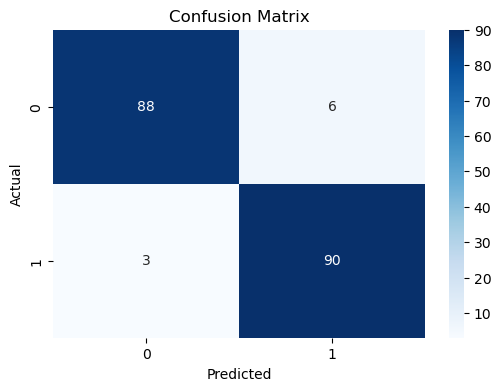

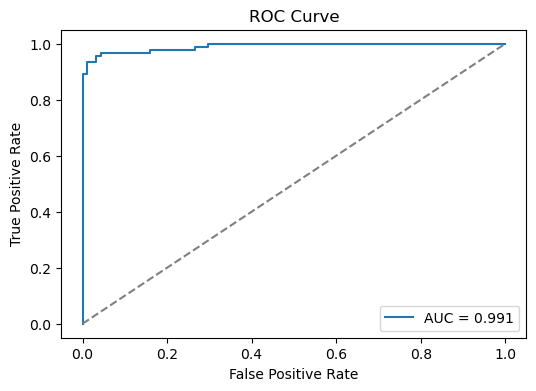

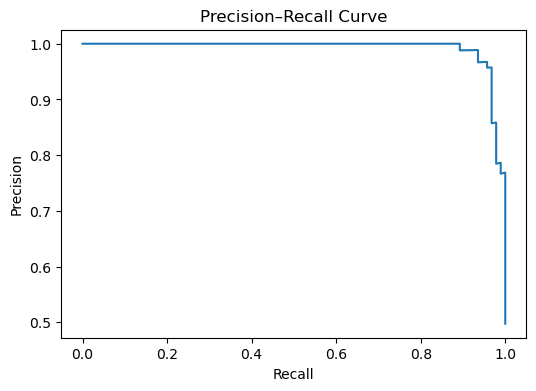


Logistic Regression Coefficients (Feature Influence):
                          Feature  Coefficient
7                 Calories_Burned     3.626993
9           Water_Intake (liters)     1.914266
2                      Height (m)     1.825743
1                     Weight (kg)     1.059635
0                             Age     0.425761
14               Workout_Strength     0.380984
12                            BMI     0.357486
5                     Resting_BPM     0.084657
15                   Workout_Yoga     0.080314
13                   Workout_HIIT     0.021141
10  Workout_Frequency (days/week)    -0.218101
3                         Max_BPM    -0.270044
11               Experience_Level    -1.050898
4                         Avg_BPM    -1.136865
8                  Fat_Percentage    -1.392753
6        Session_Duration (hours)    -3.520522


C:\Users\Admin\AppData\Local\Temp\ipykernel_14172\4274752300.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='viridis')


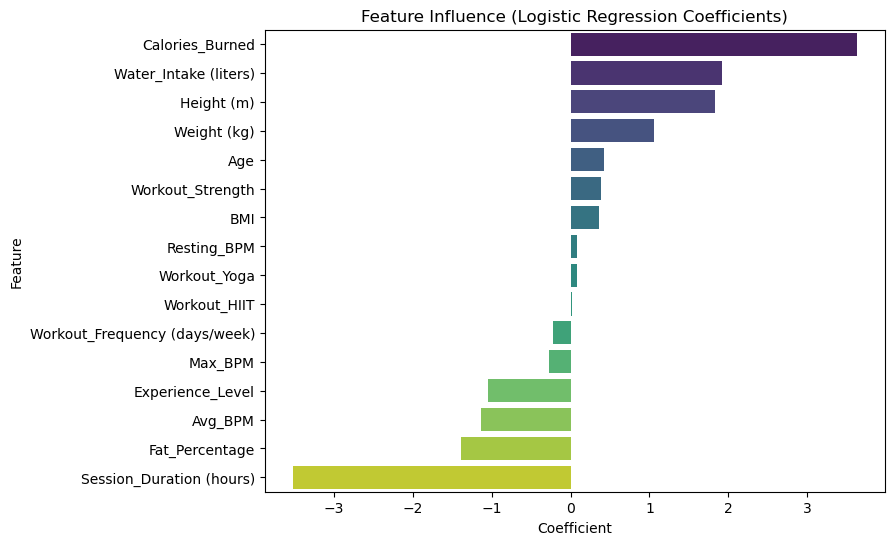

In [13]:
# ============================================================
#   LOGISTIC REGRESSION — FULL MODEL EVALUATION SUITE
#   This cell trains the model and evaluates it using:
#     ✔ Accuracy
#     ✔ Classification Report
#     ✔ Confusion Matrix
#     ✔ ROC Curve + AUC
#     ✔ Precision–Recall Curve
#     ✔ Coefficients (feature influence)
#   Every section includes comments explaining what to look for.
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
import pandas as pd

# ------------------------------------------------------------
# 1. Train the Logistic Regression model
# ------------------------------------------------------------
# Logistic Regression works best with scaled data.
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]  # needed for ROC/PR curves


# ------------------------------------------------------------
# 2. Accuracy Score
# ------------------------------------------------------------
# Accuracy = proportion of correct predictions.
# Good for balanced datasets. If classes are imbalanced,
# accuracy alone can be misleading.
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy:.4f}")


# ------------------------------------------------------------
# 3. Classification Report
# ------------------------------------------------------------
# Shows precision, recall, and F1-score for each class.
# Precision = how many predicted positives were correct.
# Recall = how many actual positives were found.
# F1 = balance between precision and recall.
# Look for balanced values across both classes.
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))


# ------------------------------------------------------------
# 4. Confusion Matrix
# ------------------------------------------------------------
# Shows EXACTLY where the model is making mistakes.
# Diagonal = correct predictions.
# Off-diagonal = errors.
cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# ------------------------------------------------------------
# 5. ROC Curve + AUC Score
# ------------------------------------------------------------
# ROC curve shows how well the model separates the two classes.
# AUC close to 1.0 = excellent.
# AUC around 0.5 = random guessing.
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# ------------------------------------------------------------
# 6. Precision–Recall Curve
# ------------------------------------------------------------
# Useful when one class is less common.
# Look for curves that stay high (good precision)
# and far right (good recall).
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_lr)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


# ------------------------------------------------------------
# 7. Logistic Regression Coefficients
# ------------------------------------------------------------
# Shows how each feature influences the prediction.
# Positive coefficient = pushes prediction toward class 1.
# Negative coefficient = pushes prediction toward class 0.
# Look for features with large absolute values.
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nLogistic Regression Coefficients (Feature Influence):")
print(coef_df)

plt.figure(figsize=(8,6))
sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='viridis')
plt.title("Feature Influence (Logistic Regression Coefficients)")
plt.show()


In [4]:
# ============================================================
# SUPPORT VECTOR MACHINE (SVM)
# Excellent for binary classification. Works best with scaling.
# Look for high accuracy and strong separation between classes.
# ============================================================

from sklearn.svm import SVC

svm_model = SVC(probability=True)  # probability=True needed for ROC curves
svm_model.fit(X_train_scaled, y_train)

y_pred_svm = svm_model.predict(X_test_scaled)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))


SVM Accuracy: 0.9572192513368984


Accuracy: 0.9572

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        94
           1       0.95      0.97      0.96        93

    accuracy                           0.96       187
   macro avg       0.96      0.96      0.96       187
weighted avg       0.96      0.96      0.96       187



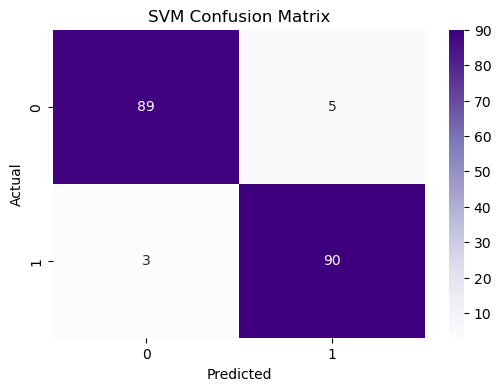

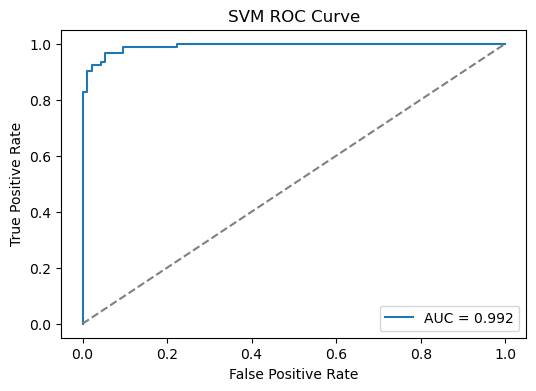

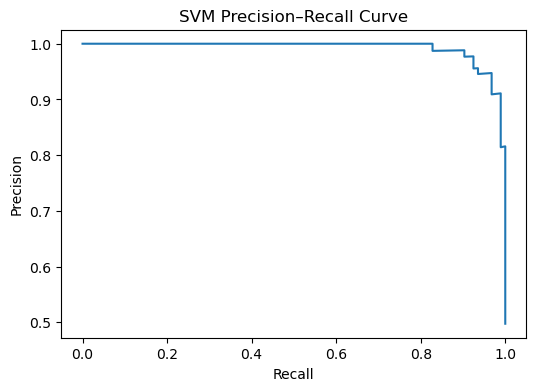


Number of Support Vectors: 260
Support Vectors per Class: [126 134]


In [14]:
# ============================================================
#   SUPPORT VECTOR MACHINE (SVM) — FULL MODEL EVALUATION
#   This cell trains the SVM model and evaluates it using:
#     ✔ Accuracy
#     ✔ Classification Report
#     ✔ Confusion Matrix
#     ✔ ROC Curve + AUC
#     ✔ Precision–Recall Curve
#     ✔ Support Vectors (unique to SVM)
#   Every section includes comments explaining what to look for.
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
import pandas as pd

# ------------------------------------------------------------
# 1. Train the SVM model
# ------------------------------------------------------------
# SVM works best with scaled data.
# probability=True allows us to compute ROC and PR curves.
svm_model = SVC(probability=True, kernel='rbf')
svm_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_svm = svm_model.predict(X_test_scaled)
y_prob_svm = svm_model.predict_proba(X_test_scaled)[:, 1]


# ------------------------------------------------------------
# 2. Accuracy Score
# ------------------------------------------------------------
# Accuracy = proportion of correct predictions.
# SVM often performs very well on binary classification.
accuracy = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy: {accuracy:.4f}")


# ------------------------------------------------------------
# 3. Classification Report
# ------------------------------------------------------------
# Shows precision, recall, and F1-score for each class.
# Look for balanced values across both classes.
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))


# ------------------------------------------------------------
# 4. Confusion Matrix
# ------------------------------------------------------------
# Shows EXACTLY where the model is making mistakes.
# Diagonal = correct predictions.
# Off-diagonal = errors.
cm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# ------------------------------------------------------------
# 5. ROC Curve + AUC Score
# ------------------------------------------------------------
# ROC curve shows how well the model separates the two classes.
# AUC close to 1.0 = excellent.
fpr, tpr, thresholds = roc_curve(y_test, y_prob_svm)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.title("SVM ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# ------------------------------------------------------------
# 6. Precision–Recall Curve
# ------------------------------------------------------------
# Useful when one class is less common.
# Look for curves that stay high (good precision)
# and far right (good recall).
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_svm)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.title("SVM Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


# ------------------------------------------------------------
# 7. SVM Support Vectors (unique to SVM)
# ------------------------------------------------------------
# Support vectors are the data points closest to the decision boundary.
# Fewer support vectors = simpler, more generalisable model.
# Many support vectors = more complex model.
num_support_vectors = svm_model.support_.shape[0]
print(f"\nNumber of Support Vectors: {num_support_vectors}")

# Breakdown per class
print("Support Vectors per Class:", svm_model.n_support_)


In [5]:
# ============================================================
# K-NEAREST NEIGHBORS (KNN)
# Looks at the 'closest' data points. Needs scaling.
# Look for performance drop if dataset is high-dimensional.
# ============================================================

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)

print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))


KNN Accuracy: 0.946524064171123


Accuracy: 0.9465

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        94
           1       0.97      0.92      0.95        93

    accuracy                           0.95       187
   macro avg       0.95      0.95      0.95       187
weighted avg       0.95      0.95      0.95       187



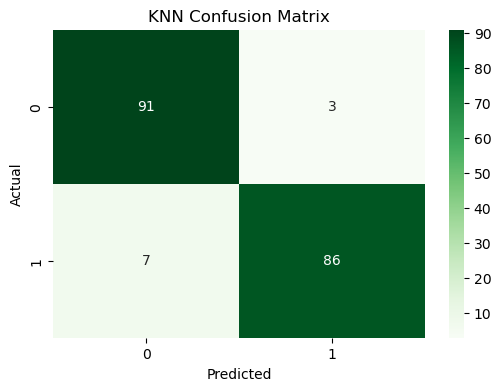

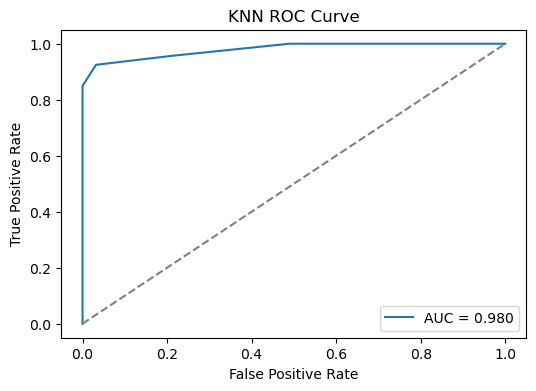

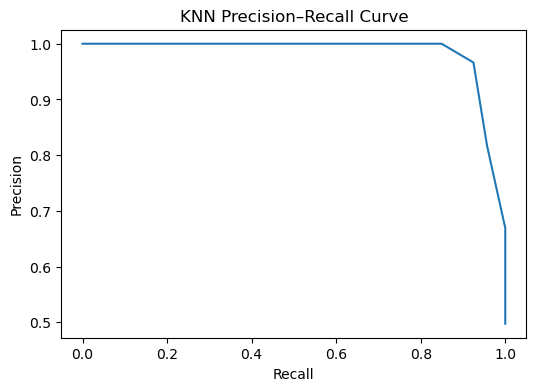


Average distance to 5 nearest neighbors: 2.5601
Lower values mean the data clusters well (good for KNN).


In [15]:
# ============================================================
#   K-NEAREST NEIGHBORS (KNN) — FULL MODEL EVALUATION
#   This cell trains the KNN model and evaluates it using:
#     ✔ Accuracy
#     ✔ Classification Report
#     ✔ Confusion Matrix
#     ✔ ROC Curve + AUC
#     ✔ Precision–Recall Curve
#     ✔ Distance-based intuition (unique to KNN)
#   Every section includes comments explaining what to look for.
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
import numpy as np

# ------------------------------------------------------------
# 1. Train the KNN model
# ------------------------------------------------------------
# KNN relies heavily on distances between points.
# Scaling is CRITICAL — without it, features with large ranges dominate.
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Predictions
y_pred_knn = knn.predict(X_test_scaled)
y_prob_knn = knn.predict_proba(X_test_scaled)[:, 1]  # needed for ROC/PR curves


# ------------------------------------------------------------
# 2. Accuracy Score
# ------------------------------------------------------------
# Accuracy = proportion of correct predictions.
# KNN can struggle in high-dimensional datasets.
accuracy = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy: {accuracy:.4f}")


# ------------------------------------------------------------
# 3. Classification Report
# ------------------------------------------------------------
# Shows precision, recall, and F1-score for each class.
# Look for balanced values across both classes.
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))


# ------------------------------------------------------------
# 4. Confusion Matrix
# ------------------------------------------------------------
# Shows EXACTLY where the model is making mistakes.
# Diagonal = correct predictions.
# Off-diagonal = errors.
cm = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# ------------------------------------------------------------
# 5. ROC Curve + AUC Score
# ------------------------------------------------------------
# ROC curve shows how well the model separates the two classes.
# AUC close to 1.0 = excellent.
fpr, tpr, thresholds = roc_curve(y_test, y_prob_knn)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.title("KNN ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# ------------------------------------------------------------
# 6. Precision–Recall Curve
# ------------------------------------------------------------
# Useful when one class is less common.
# Look for curves that stay high (good precision)
# and far right (good recall).
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_knn)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.title("KNN Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


# ------------------------------------------------------------
# 7. Distance-based intuition (unique to KNN)
# ------------------------------------------------------------
# KNN predictions depend on the distances to the nearest neighbors.
# We can inspect the average distance to the 5 nearest neighbors.
# Lower distances = tighter clusters = easier classification.
distances, indices = knn.kneighbors(X_test_scaled)

avg_distance = np.mean(distances)
print(f"\nAverage distance to 5 nearest neighbors: {avg_distance:.4f}")
print("Lower values mean the data clusters well (good for KNN).")


In [6]:
# ============================================================
# DECISION TREE
# Easy to interpret. No scaling needed. Can overfit.
# Look for high training accuracy but lower test accuracy (overfitting).
# ============================================================

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)  # no scaling needed

y_pred_tree = tree.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))


Decision Tree Accuracy: 0.9518716577540107


Test Accuracy: 0.9519
Train Accuracy: 1.0000
If Train >> Test, the model is overfitting.

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95        94
           1       0.92      0.99      0.95        93

    accuracy                           0.95       187
   macro avg       0.95      0.95      0.95       187
weighted avg       0.95      0.95      0.95       187



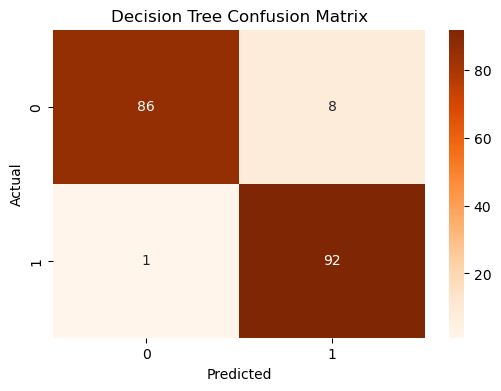

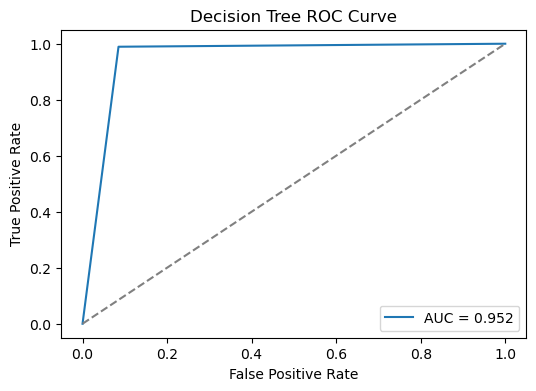

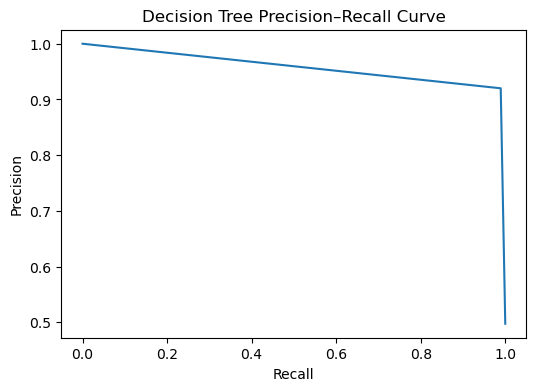


Feature Importance:
                          Feature  Importance
9           Water_Intake (liters)    0.506969
2                      Height (m)    0.201165
8                  Fat_Percentage    0.112306
1                     Weight (kg)    0.103372
6        Session_Duration (hours)    0.038151
7                 Calories_Burned    0.010022
12                            BMI    0.008910
4                         Avg_BPM    0.005646
10  Workout_Frequency (days/week)    0.004302
15                   Workout_Yoga    0.004033
13                   Workout_HIIT    0.003585
3                         Max_BPM    0.000869
0                             Age    0.000670
5                     Resting_BPM    0.000000
11               Experience_Level    0.000000
14               Workout_Strength    0.000000


C:\Users\Admin\AppData\Local\Temp\ipykernel_14172\2820223216.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='autumn')


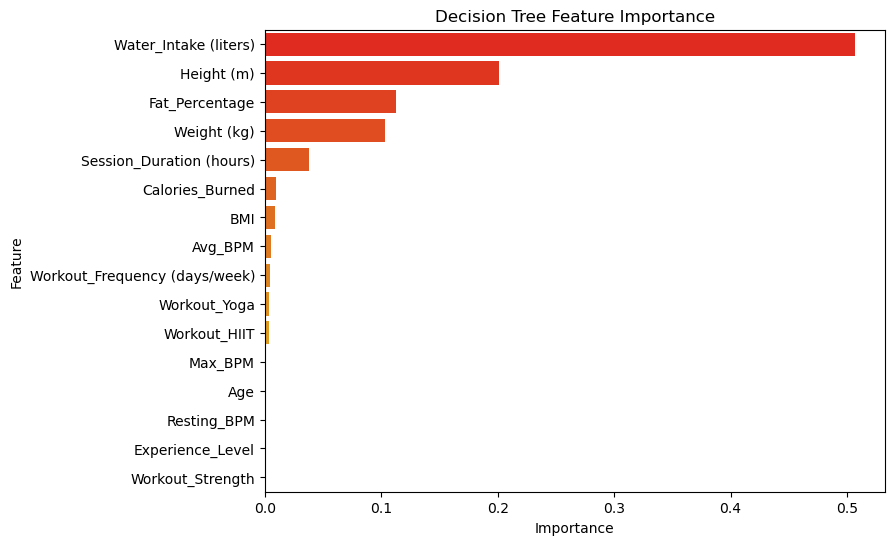

In [16]:
# ============================================================
#   DECISION TREE — FULL MODEL EVALUATION SUITE
#   This cell trains the Decision Tree and evaluates it using:
#     ✔ Accuracy
#     ✔ Classification Report
#     ✔ Confusion Matrix
#     ✔ ROC Curve + AUC
#     ✔ Precision–Recall Curve
#     ✔ Feature Importance (unique to trees)
#     ✔ Overfitting check (train vs test accuracy)
#   Every section includes comments explaining what to look for.
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
import pandas as pd

# ------------------------------------------------------------
# 1. Train the Decision Tree model
# ------------------------------------------------------------
# Trees do NOT require scaling.
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

# Predictions
y_pred_tree = tree.predict(X_test)
y_prob_tree = tree.predict_proba(X_test)[:, 1]  # needed for ROC/PR curves


# ------------------------------------------------------------
# 2. Accuracy Score (Test Set)
# ------------------------------------------------------------
# Accuracy = proportion of correct predictions.
# Trees often overfit, so accuracy alone is not enough.
test_accuracy = accuracy_score(y_test, y_pred_tree)
print(f"Test Accuracy: {test_accuracy:.4f}")


# ------------------------------------------------------------
# 3. Overfitting Check — Train Accuracy vs Test Accuracy
# ------------------------------------------------------------
# If train accuracy is much higher than test accuracy,
# the tree is memorising the training data (overfitting).
train_accuracy = accuracy_score(y_train, tree.predict(X_train))
print(f"Train Accuracy: {train_accuracy:.4f}")
print("If Train >> Test, the model is overfitting.\n")


# ------------------------------------------------------------
# 4. Classification Report
# ------------------------------------------------------------
# Shows precision, recall, and F1-score for each class.
# Look for balanced values across both classes.
print("Classification Report:")
print(classification_report(y_test, y_pred_tree))


# ------------------------------------------------------------
# 5. Confusion Matrix
# ------------------------------------------------------------
# Shows EXACTLY where the model is making mistakes.
# Diagonal = correct predictions.
# Off-diagonal = errors.
cm = confusion_matrix(y_test, y_pred_tree)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# ------------------------------------------------------------
# 6. ROC Curve + AUC Score
# ------------------------------------------------------------
# ROC curve shows how well the model separates the two classes.
# AUC close to 1.0 = excellent.
fpr, tpr, thresholds = roc_curve(y_test, y_prob_tree)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.title("Decision Tree ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# ------------------------------------------------------------
# 7. Precision–Recall Curve
# ------------------------------------------------------------
# Useful when one class is less common.
# Look for curves that stay high (good precision)
# and far right (good recall).
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_tree)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.title("Decision Tree Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


# ------------------------------------------------------------
# 8. Feature Importance (unique to Decision Trees)
# ------------------------------------------------------------
# Shows which features the tree used most for splitting.
# Higher importance = more influence on predictions.
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': tree.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)

plt.figure(figsize=(8,6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='autumn')
plt.title("Decision Tree Feature Importance")
plt.show()


In [7]:
# ============================================================
# RANDOM FOREST
# Ensemble of many trees. Handles non-linear patterns well.
# Look for strong accuracy and stable performance.
# ============================================================

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)  # scaling not required

y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest Accuracy: 0.983957219251337


Test Accuracy: 0.9840
Train Accuracy: 1.0000
If Train >> Test, the model may be overfitting.

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        94
           1       0.98      0.99      0.98        93

    accuracy                           0.98       187
   macro avg       0.98      0.98      0.98       187
weighted avg       0.98      0.98      0.98       187



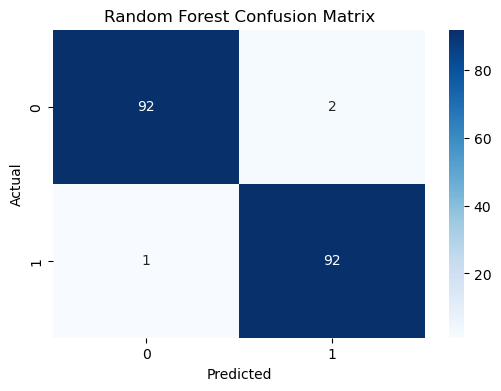

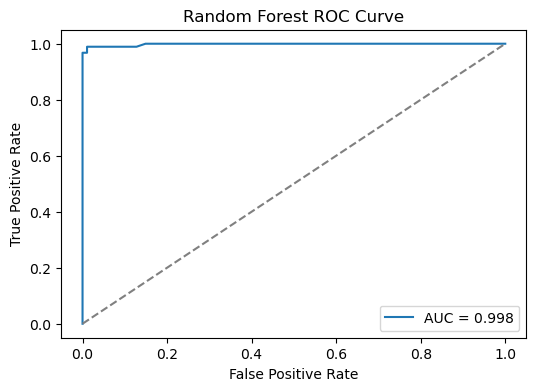

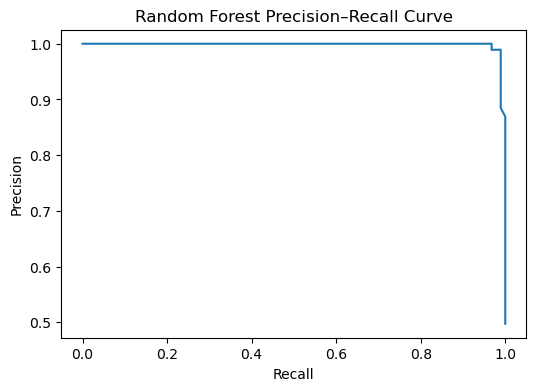


Feature Importance:
                          Feature  Importance
9           Water_Intake (liters)    0.347296
1                     Weight (kg)    0.190663
2                      Height (m)    0.157448
8                  Fat_Percentage    0.143389
12                            BMI    0.041594
6        Session_Duration (hours)    0.026344
7                 Calories_Burned    0.017534
11               Experience_Level    0.015176
4                         Avg_BPM    0.014048
3                         Max_BPM    0.012145
5                     Resting_BPM    0.011410
0                             Age    0.009764
10  Workout_Frequency (days/week)    0.006064
14               Workout_Strength    0.002882
15                   Workout_Yoga    0.002322
13                   Workout_HIIT    0.001922


C:\Users\Admin\AppData\Local\Temp\ipykernel_14172\620029543.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


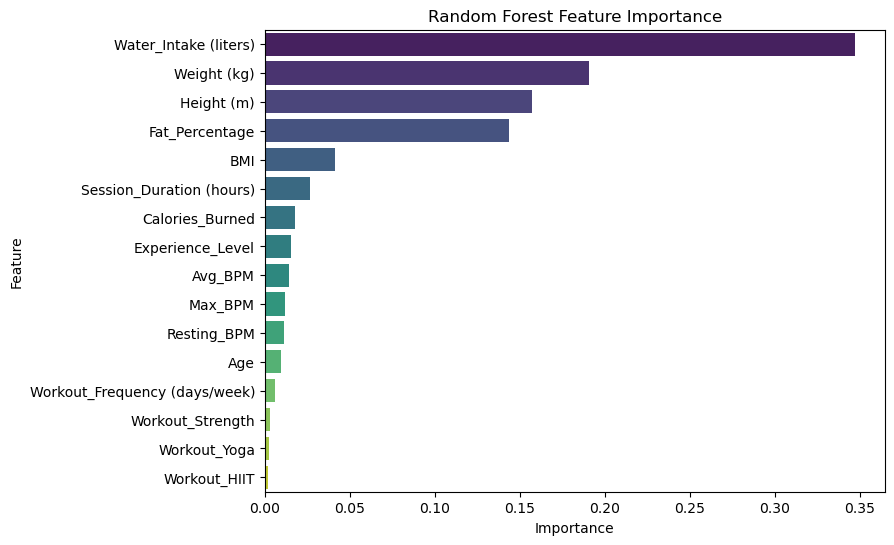

In [17]:
# ============================================================
#   RANDOM FOREST — FULL MODEL EVALUATION SUITE
#   This cell trains the Random Forest and evaluates it using:
#     ✔ Accuracy
#     ✔ Classification Report
#     ✔ Confusion Matrix
#     ✔ ROC Curve + AUC
#     ✔ Precision–Recall Curve
#     ✔ Feature Importance (unique to tree ensembles)
#     ✔ Overfitting check (train vs test accuracy)
#   Every section includes comments explaining what to look for.
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
import pandas as pd

# ------------------------------------------------------------
# 1. Train the Random Forest model
# ------------------------------------------------------------
# Random Forest = many decision trees combined.
# Scaling is NOT required.
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]  # needed for ROC/PR curves


# ------------------------------------------------------------
# 2. Accuracy Score (Test Set)
# ------------------------------------------------------------
# Accuracy = proportion of correct predictions.
# Random Forests usually perform strongly and generalise well.
test_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Test Accuracy: {test_accuracy:.4f}")


# ------------------------------------------------------------
# 3. Overfitting Check — Train Accuracy vs Test Accuracy
# ------------------------------------------------------------
# If train accuracy is much higher than test accuracy,
# the model may be overfitting.
train_accuracy = accuracy_score(y_train, rf.predict(X_train))
print(f"Train Accuracy: {train_accuracy:.4f}")
print("If Train >> Test, the model may be overfitting.\n")


# ------------------------------------------------------------
# 4. Classification Report
# ------------------------------------------------------------
# Shows precision, recall, and F1-score for each class.
# Look for balanced values across both classes.
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))


# ------------------------------------------------------------
# 5. Confusion Matrix
# ------------------------------------------------------------
# Shows EXACTLY where the model is making mistakes.
# Diagonal = correct predictions.
# Off-diagonal = errors.
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# ------------------------------------------------------------
# 6. ROC Curve + AUC Score
# ------------------------------------------------------------
# ROC curve shows how well the model separates the two classes.
# AUC close to 1.0 = excellent.
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.title("Random Forest ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# ------------------------------------------------------------
# 7. Precision–Recall Curve
# ------------------------------------------------------------
# Useful when one class is less common.
# Look for curves that stay high (good precision)
# and far right (good recall).
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_rf)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.title("Random Forest Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


# ------------------------------------------------------------
# 8. Feature Importance (unique to Random Forests)
# ------------------------------------------------------------
# Shows which features the forest relies on most.
# Higher importance = more influence on predictions.
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)

plt.figure(figsize=(8,6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Random Forest Feature Importance")
plt.show()


In [8]:
# ============================================================
# GRADIENT BOOSTING CLASSIFIER
# Learns from mistakes of previous trees. Very strong model.
# Look for improved accuracy over Random Forest.
# ============================================================

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))


Gradient Boosting Accuracy: 0.9786096256684492


Test Accuracy: 0.9786
Train Accuracy: 0.9987
If Train >> Test, the model may be overfitting.

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        94
           1       0.97      0.99      0.98        93

    accuracy                           0.98       187
   macro avg       0.98      0.98      0.98       187
weighted avg       0.98      0.98      0.98       187



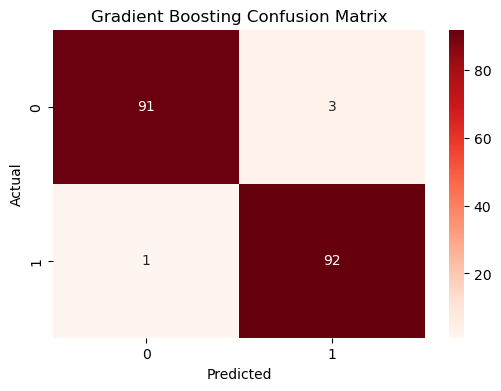

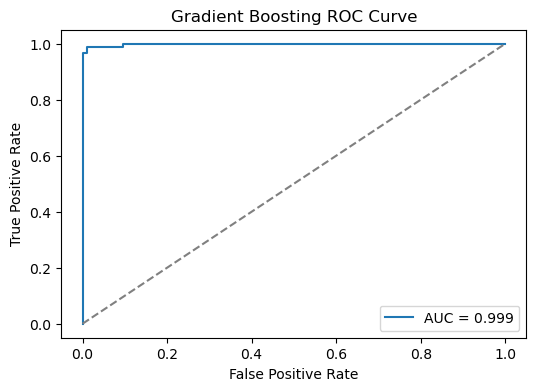

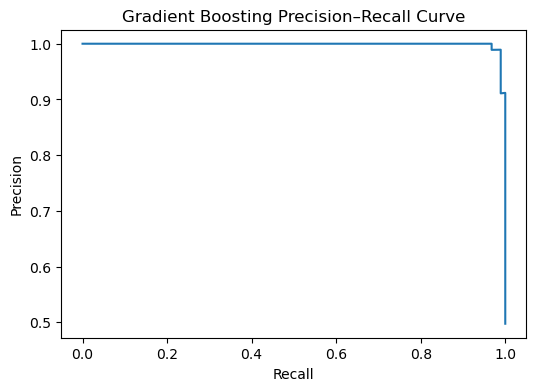


Feature Importance:
                          Feature  Importance
9           Water_Intake (liters)    0.537074
2                      Height (m)    0.225862
1                     Weight (kg)    0.100445
8                  Fat_Percentage    0.100039
6        Session_Duration (hours)    0.019886
7                 Calories_Burned    0.005093
4                         Avg_BPM    0.002478
0                             Age    0.002224
11               Experience_Level    0.002012
5                     Resting_BPM    0.001298
12                            BMI    0.001187
3                         Max_BPM    0.001099
14               Workout_Strength    0.001077
10  Workout_Frequency (days/week)    0.000226
13                   Workout_HIIT    0.000000
15                   Workout_Yoga    0.000000


C:\Users\Admin\AppData\Local\Temp\ipykernel_14172\3042116084.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='magma')


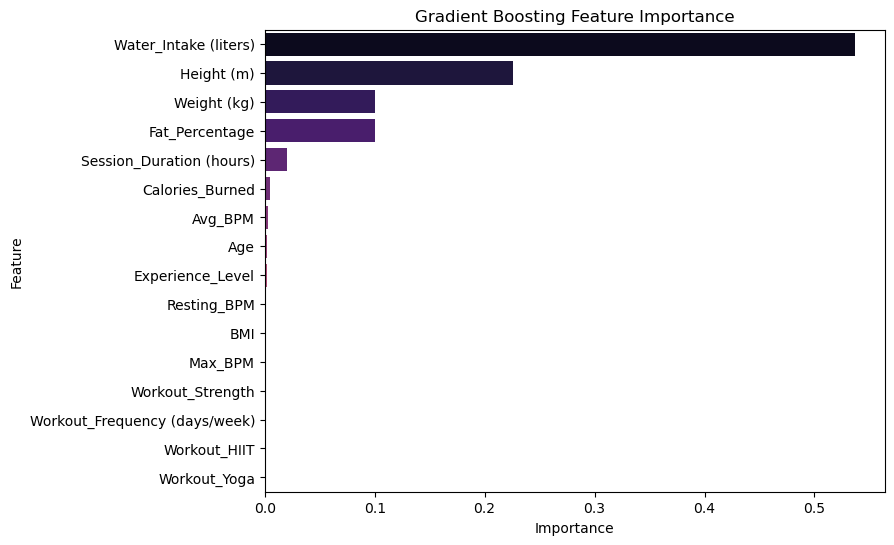

In [18]:
# ============================================================
#   GRADIENT BOOSTING CLASSIFIER — FULL MODEL EVALUATION
#   This cell trains the Gradient Boosting model and evaluates it using:
#     ✔ Accuracy
#     ✔ Classification Report
#     ✔ Confusion Matrix
#     ✔ ROC Curve + AUC
#     ✔ Precision–Recall Curve
#     ✔ Feature Importance (unique to boosting)
#     ✔ Overfitting check (train vs test accuracy)
#   Every section includes comments explaining what to look for.
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
import pandas as pd

# ------------------------------------------------------------
# 1. Train the Gradient Boosting model
# ------------------------------------------------------------
# Gradient Boosting builds trees sequentially, each correcting the last.
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

# Predictions
y_pred_gb = gb.predict(X_test)
y_prob_gb = gb.predict_proba(X_test)[:, 1]  # needed for ROC/PR curves


# ------------------------------------------------------------
# 2. Accuracy Score (Test Set)
# ------------------------------------------------------------
# Accuracy = proportion of correct predictions.
# Gradient Boosting often outperforms Random Forest on structured data.
test_accuracy = accuracy_score(y_test, y_pred_gb)
print(f"Test Accuracy: {test_accuracy:.4f}")


# ------------------------------------------------------------
# 3. Overfitting Check — Train Accuracy vs Test Accuracy
# ------------------------------------------------------------
# If train accuracy is much higher than test accuracy,
# the model may be overfitting.
train_accuracy = accuracy_score(y_train, gb.predict(X_train))
print(f"Train Accuracy: {train_accuracy:.4f}")
print("If Train >> Test, the model may be overfitting.\n")


# ------------------------------------------------------------
# 4. Classification Report
# ------------------------------------------------------------
# Shows precision, recall, and F1-score for each class.
# Look for balanced values across both classes.
print("Classification Report:")
print(classification_report(y_test, y_pred_gb))


# ------------------------------------------------------------
# 5. Confusion Matrix
# ------------------------------------------------------------
# Shows EXACTLY where the model is making mistakes.
# Diagonal = correct predictions.
# Off-diagonal = errors.
cm = confusion_matrix(y_test, y_pred_gb)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title("Gradient Boosting Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# ------------------------------------------------------------
# 6. ROC Curve + AUC Score
# ------------------------------------------------------------
# ROC curve shows how well the model separates the two classes.
# AUC close to 1.0 = excellent.
fpr, tpr, thresholds = roc_curve(y_test, y_prob_gb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.title("Gradient Boosting ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# ------------------------------------------------------------
# 7. Precision–Recall Curve
# ------------------------------------------------------------
# Useful when one class is less common.
# Look for curves that stay high (good precision)
# and far right (good recall).
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_gb)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.title("Gradient Boosting Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


# ------------------------------------------------------------
# 8. Feature Importance (unique to boosting)
# ------------------------------------------------------------
# Shows which features the boosting model relies on most.
# Higher importance = more influence on predictions.
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)

plt.figure(figsize=(8,6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='magma')
plt.title("Gradient Boosting Feature Importance")
plt.show()


In [11]:
# ============================================================
# XGBOOST (if installed)
# Extremely strong for tabular data. Often best performer.
# Look for high accuracy and stable generalisation.
# ============================================================

from xgboost import XGBClassifier

xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))


XGBoost Accuracy: 0.983957219251337


Test Accuracy: 0.9840
Train Accuracy: 1.0000
If Train >> Test, the model may be overfitting.

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        94
           1       0.98      0.99      0.98        93

    accuracy                           0.98       187
   macro avg       0.98      0.98      0.98       187
weighted avg       0.98      0.98      0.98       187



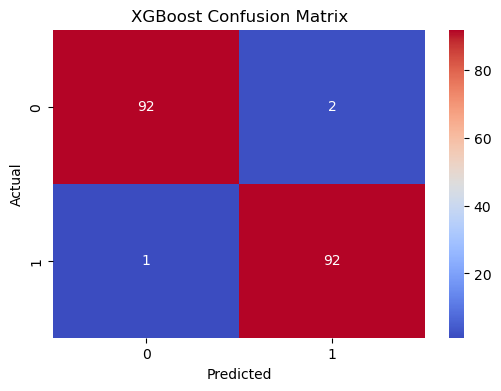

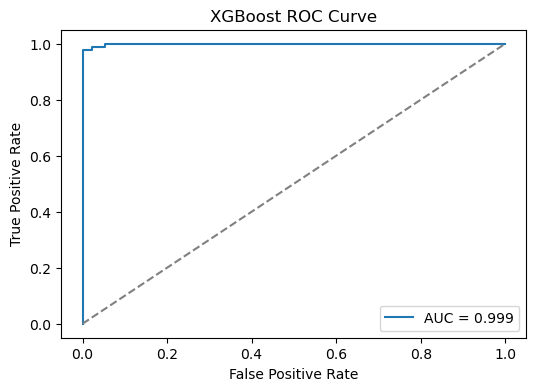

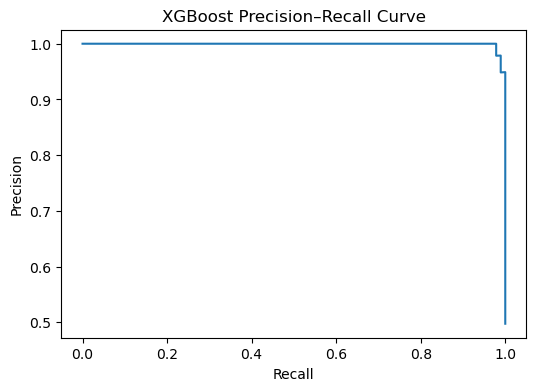


Feature Importance:
                          Feature  Importance
9           Water_Intake (liters)    0.506976
2                      Height (m)    0.199339
1                     Weight (kg)    0.089580
6        Session_Duration (hours)    0.049827
8                  Fat_Percentage    0.043817
14               Workout_Strength    0.023794
13                   Workout_HIIT    0.016759
3                         Max_BPM    0.011810
4                         Avg_BPM    0.010850
7                 Calories_Burned    0.009286
12                            BMI    0.008062
0                             Age    0.007485
10  Workout_Frequency (days/week)    0.006891
5                     Resting_BPM    0.005753
11               Experience_Level    0.005206
15                   Workout_Yoga    0.004566


C:\Users\Admin\AppData\Local\Temp\ipykernel_14172\4154233332.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='inferno')


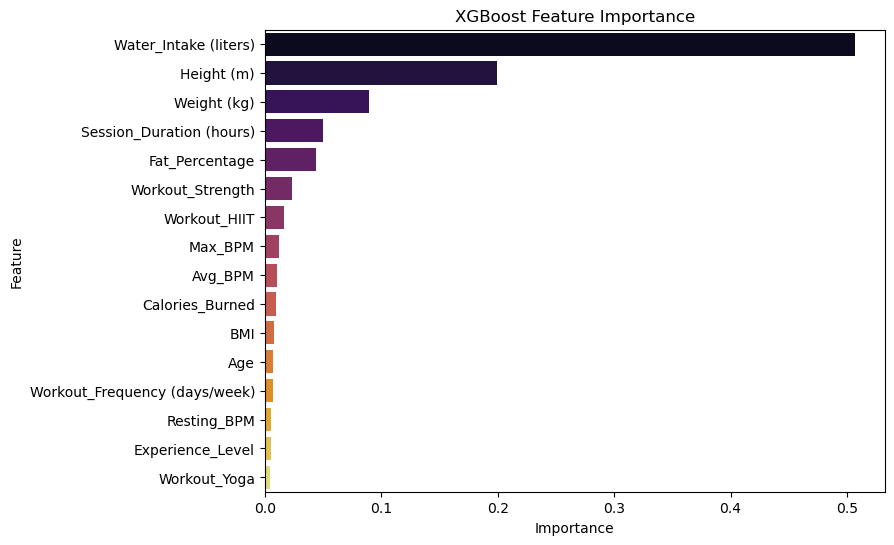

In [19]:
# ============================================================
#   XGBOOST CLASSIFIER — FULL MODEL EVALUATION SUITE
#   This cell trains the XGBoost model and evaluates it using:
#     ✔ Accuracy
#     ✔ Classification Report
#     ✔ Confusion Matrix
#     ✔ ROC Curve + AUC
#     ✔ Precision–Recall Curve
#     ✔ Feature Importance (unique to boosting)
#     ✔ Overfitting check (train vs test accuracy)
#   Every section includes comments explaining what to look for.
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
import pandas as pd

# ------------------------------------------------------------
# 1. Train the XGBoost model
# ------------------------------------------------------------
# eval_metric='logloss' avoids warnings and ensures proper training.
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]  # needed for ROC/PR curves


# ------------------------------------------------------------
# 2. Accuracy Score (Test Set)
# ------------------------------------------------------------
# Accuracy = proportion of correct predictions.
# XGBoost often performs extremely well on structured/tabular data.
test_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"Test Accuracy: {test_accuracy:.4f}")


# ------------------------------------------------------------
# 3. Overfitting Check — Train Accuracy vs Test Accuracy
# ------------------------------------------------------------
# If train accuracy is much higher than test accuracy,
# the model may be overfitting.
train_accuracy = accuracy_score(y_train, xgb.predict(X_train))
print(f"Train Accuracy: {train_accuracy:.4f}")
print("If Train >> Test, the model may be overfitting.\n")


# ------------------------------------------------------------
# 4. Classification Report
# ------------------------------------------------------------
# Shows precision, recall, and F1-score for each class.
# Look for balanced values across both classes.
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))


# ------------------------------------------------------------
# 5. Confusion Matrix
# ------------------------------------------------------------
# Shows EXACTLY where the model is making mistakes.
# Diagonal = correct predictions.
# Off-diagonal = errors.
cm = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# ------------------------------------------------------------
# 6. ROC Curve + AUC Score
# ------------------------------------------------------------
# ROC curve shows how well the model separates the two classes.
# AUC close to 1.0 = excellent.
fpr, tpr, thresholds = roc_curve(y_test, y_prob_xgb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.title("XGBoost ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# ------------------------------------------------------------
# 7. Precision–Recall Curve
# ------------------------------------------------------------
# Useful when one class is less common.
# Look for curves that stay high (good precision)
# and far right (good recall).
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_xgb)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.title("XGBoost Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


# ------------------------------------------------------------
# 8. Feature Importance (unique to boosting)
# ------------------------------------------------------------
# Shows which features XGBoost relies on most.
# Higher importance = more influence on predictions.
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)

plt.figure(figsize=(8,6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='inferno')
plt.title("XGBoost Feature Importance")
plt.show()


In [12]:
# ============================================================
# NEURAL NETWORK (MLPClassifier)
# Good for complex relationships. Needs scaling.
# Look for improvements over simpler models.
# ============================================================

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train)

y_pred_mlp = mlp.predict(X_test_scaled)

print("Neural Network Accuracy:", accuracy_score(y_test, y_pred_mlp))


Neural Network Accuracy: 0.9625668449197861


Test Accuracy: 0.9626
Train Accuracy: 1.0000
If Train >> Test, the model may be overfitting.

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        94
           1       0.95      0.98      0.96        93

    accuracy                           0.96       187
   macro avg       0.96      0.96      0.96       187
weighted avg       0.96      0.96      0.96       187



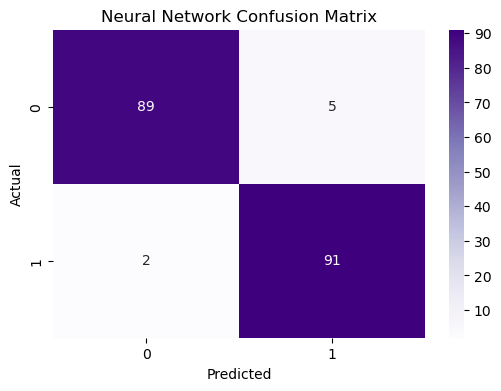

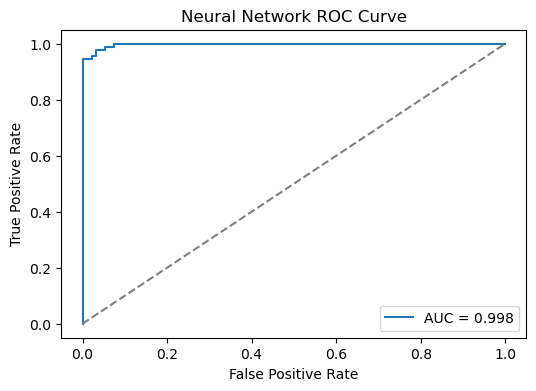

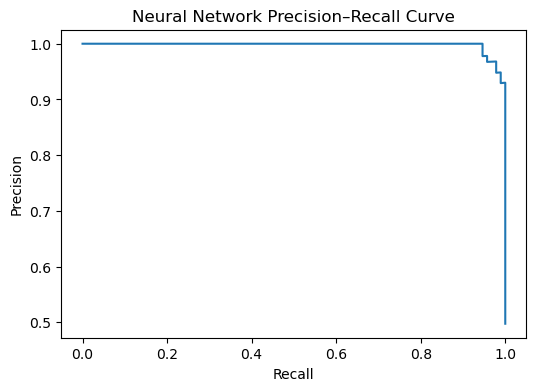

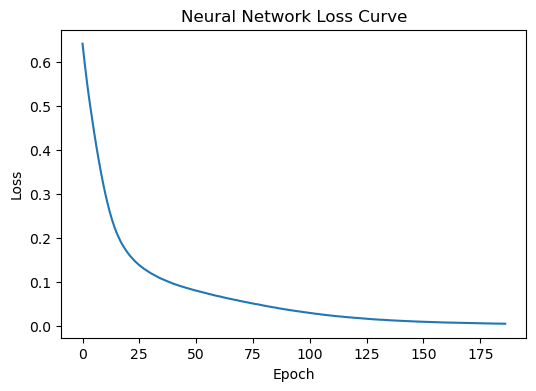

In [20]:
# ============================================================
#   NEURAL NETWORK (MLPClassifier) — FULL MODEL EVALUATION
#   This cell trains the MLP model and evaluates it using:
#     ✔ Accuracy
#     ✔ Classification Report
#     ✔ Confusion Matrix
#     ✔ ROC Curve + AUC
#     ✔ Precision–Recall Curve
#     ✔ Loss Curve (unique to neural networks)
#     ✔ Overfitting check (train vs test accuracy)
#   Every section includes comments explaining what to look for.
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
import pandas as pd

# ------------------------------------------------------------
# 1. Train the Neural Network model
# ------------------------------------------------------------
# Neural networks REQUIRE scaling for stable training.
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    max_iter=500,
    random_state=42
)
mlp.fit(X_train_scaled, y_train)

# Predictions
y_pred_mlp = mlp.predict(X_test_scaled)
y_prob_mlp = mlp.predict_proba(X_test_scaled)[:, 1]  # needed for ROC/PR curves


# ------------------------------------------------------------
# 2. Accuracy Score (Test Set)
# ------------------------------------------------------------
# Accuracy = proportion of correct predictions.
# Neural networks can outperform simpler models if patterns are complex.
test_accuracy = accuracy_score(y_test, y_pred_mlp)
print(f"Test Accuracy: {test_accuracy:.4f}")


# ------------------------------------------------------------
# 3. Overfitting Check — Train Accuracy vs Test Accuracy
# ------------------------------------------------------------
# If train accuracy is much higher than test accuracy,
# the model may be overfitting.
train_accuracy = accuracy_score(y_train, mlp.predict(X_train_scaled))
print(f"Train Accuracy: {train_accuracy:.4f}")
print("If Train >> Test, the model may be overfitting.\n")


# ------------------------------------------------------------
# 4. Classification Report
# ------------------------------------------------------------
# Shows precision, recall, and F1-score for each class.
# Look for balanced values across both classes.
print("Classification Report:")
print(classification_report(y_test, y_pred_mlp))


# ------------------------------------------------------------
# 5. Confusion Matrix
# ------------------------------------------------------------
# Shows EXACTLY where the model is making mistakes.
# Diagonal = correct predictions.
# Off-diagonal = errors.
cm = confusion_matrix(y_test, y_pred_mlp)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("Neural Network Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# ------------------------------------------------------------
# 6. ROC Curve + AUC Score
# ------------------------------------------------------------
# ROC curve shows how well the model separates the two classes.
# AUC close to 1.0 = excellent.
fpr, tpr, thresholds = roc_curve(y_test, y_prob_mlp)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.title("Neural Network ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# ------------------------------------------------------------
# 7. Precision–Recall Curve
# ------------------------------------------------------------
# Useful when one class is less common.
# Look for curves that stay high (good precision)
# and far right (good recall).
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_mlp)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.title("Neural Network Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


# ------------------------------------------------------------
# 8. Loss Curve (unique to neural networks)
# ------------------------------------------------------------
# Shows how the model's error decreased during training.
# A smooth downward curve = good learning.
# A jagged or flat curve = learning problems.
plt.figure(figsize=(6,4))
plt.plot(mlp.loss_curve_)
plt.title("Neural Network Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


=== MODEL PERFORMANCE COMPARISON ===
                  Model  Accuracy  Precision    Recall  F1 Score       AUC
6               XGBoost  0.983957   0.978723  0.989247  0.983957  0.999199
5     Gradient Boosting  0.978610   0.968421  0.989247  0.978723  0.998742
4         Random Forest  0.983957   0.978723  0.989247  0.983957  0.998284
7  Neural Network (MLP)  0.962567   0.947917  0.978495  0.962963  0.997712
1                   SVM  0.957219   0.947368  0.967742  0.957447  0.992107
0   Logistic Regression  0.951872   0.937500  0.967742  0.952381  0.990620
2                   KNN  0.946524   0.966292  0.924731  0.945055  0.979753
3         Decision Tree  0.951872   0.920000  0.989247  0.953368  0.952070


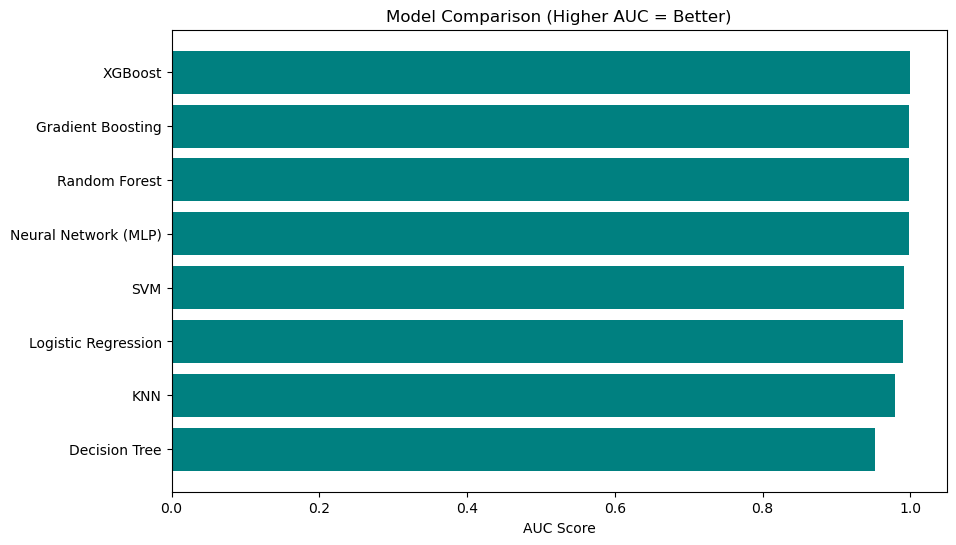

In [21]:
# ============================================================
#   MODEL COMPARISON — ACCURACY, F1, AUC, PRECISION, RECALL
#   This cell compares ALL trained models side-by-side:
#     ✔ Logistic Regression
#     ✔ SVM
#     ✔ KNN
#     ✔ Decision Tree
#     ✔ Random Forest
#     ✔ Gradient Boosting
#     ✔ XGBoost
#     ✔ Neural Network (MLP)
#   Outputs:
#     ✔ Comparison table
#     ✔ Sorted ranking
#     ✔ Bar chart of model performance
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# ------------------------------------------------------------
# 1. Collect predictions and probabilities for each model
# ------------------------------------------------------------
model_results = {
    "Logistic Regression":   (y_pred_lr,   log_reg.predict_proba(X_test_scaled)[:, 1]),
    "SVM":                   (y_pred_svm,  svm_model.predict_proba(X_test_scaled)[:, 1]),
    "KNN":                   (y_pred_knn,  knn.predict_proba(X_test_scaled)[:, 1]),
    "Decision Tree":         (y_pred_tree, tree.predict_proba(X_test)[:, 1]),
    "Random Forest":         (y_pred_rf,   rf.predict_proba(X_test)[:, 1]),
    "Gradient Boosting":     (y_pred_gb,   gb.predict_proba(X_test)[:, 1]),
    "XGBoost":               (y_pred_xgb,  xgb.predict_proba(X_test)[:, 1]),
    "Neural Network (MLP)":  (y_pred_mlp,  mlp.predict_proba(X_test_scaled)[:, 1]),
}

# ------------------------------------------------------------
# 2. Compute metrics for each model
# ------------------------------------------------------------
rows = []

for model_name, (pred, prob) in model_results.items():
    rows.append({
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred),
        "Recall": recall_score(y_test, pred),
        "F1 Score": f1_score(y_test, pred),
        "AUC": roc_auc_score(y_test, prob)
    })

results_df = pd.DataFrame(rows)

# ------------------------------------------------------------
# 3. Sort models by chosen metric (AUC is usually best)
# ------------------------------------------------------------
results_df = results_df.sort_values(by="AUC", ascending=False)
print("=== MODEL PERFORMANCE COMPARISON ===")
print(results_df)

# ------------------------------------------------------------
# 4. Visualise model performance
# ------------------------------------------------------------
plt.figure(figsize=(10,6))
plt.barh(results_df["Model"], results_df["AUC"], color="teal")
plt.xlabel("AUC Score")
plt.title("Model Comparison (Higher AUC = Better)")
plt.gca().invert_yaxis()  # best model at top
plt.show()
